In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import random
#import pylops # might not need
import math
import pyproximal

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model

In [ ]:
# code from: https://www.tensorflow.org/tutorials/generative/autoencoder

In [9]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


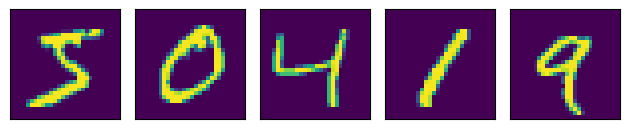

In [13]:
# representation training dataset
ns = 5
fig, ax = plt.subplots(1,ns)

for i in range(ns):
    x = x_train[i]
    ax[i].imshow(np.real(x).reshape((28,28)),clim=[0,1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.tight_layout()

In [11]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0434 - val_loss: 0.0092
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0079 - val_loss: 0.0054
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0040 - val_loss: 0.0039


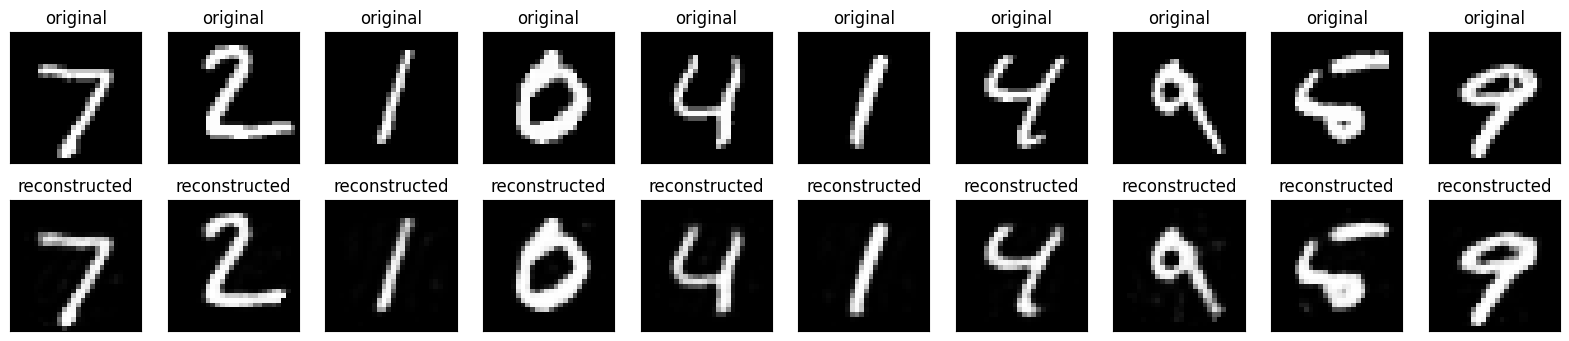

In [15]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()